# Informational Structures (general functions)

In [8]:
import numpy as np
import warnings
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import networkx as nx
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

warnings.filterwarnings('ignore')

# Euclidean distance between two points (error if different length)
def eucl_distance(v1,v2):
        return sqrt(sum([(v1[i]-v2[i])^2 for i in range(max(len(v1), len(v2)))]))

# Given alpha and gamma values, this function returns the stable points of the IS
def ISpoints(alphas, gammas):
    vrs = [var('u'+str(i)) for i in range(len(gammas))]
    Eqs = [alphas[i]*vrs[i] - vrs[i]^2 + 
           sum([vrs[i]*vrs[j]*gammas[j][i] if (i != j) else 0 
                for j in range(len(gammas))])
           for i in range(len(gammas))]
    solsRaw = solve(Eqs,vrs)
    solsLevels = [[] for i in range(len(alphas)+1)]
    for s in solsRaw:
        l = 0
        sE = []
        b = True
        for v in s:
            if b:
                val = v.rhs()
                if val<0:
                    b = False
                sE.append(val)
                if val>0:
                    l+=1
        if b:
            solsLevels[l].append(sE)            
    return flatten(solsLevels,max_level=1)

# Given alpha and gamma values, this function the global stable point. It is found numerically giving a time. 
def ISglobalPoint(alphas, gammas, times):
    ispoints = ISpoints(alphas, gammas)
    vrs = [var('u'+str(i)) for i in range(len(gammas))]
    Eqs = [alphas[i]*vrs[i] - vrs[i]^2 + 
           sum([vrs[i]*vrs[j]*gammas[j][i] if (i!=j) else 0 
                for j in range(len(gammas))])
           for i in range(len(gammas))]
    s = desolve_odeint(Eqs, [1+random() for i in range(len(alphas))], times, vrs)
    Gpoint = s[-1]
    dist = [(eucl_distance(Gpoint,ispoints[i]),ispoints[i]) for i in range(len(ispoints))]
    dist.sort()
    return dist[0][1]

# Transform an IS point into a list of 0s and 1s
def pointIS2node(solIS):
    return ''.join(['1' if i>0 else '0' for i in solIS])

# Given an IS node, this function returns its level (number of values > 0)
def levelISnode(solIS):
    return sum([1 if i>0 else 0 for i in solIS])

# True if sn2 has the same or more >0 values than sn1
def isSubset(sn1,sn2):
    b = True
    for i in range(len(sn1)):
        b = b & (sn1[i]<=sn2[i])
    return b

# Given alpha and gamma values, IS points and global solution, this function builds the IS graph.
# It returns a list with the first element the graph and the second one the node positions for a 
# better visualization. 
def graphIScoop(alphas, gammas, pointsIS, globalPoint):
    nodesLev = [[] for i in range(len(alphas)+1)]
    for n in pointsIS:
        if (n != globalPoint):
            l = levelISnode(n)
        else:
            l = max(len(alphas),levelISnode(n))
        nodesLev[l].append(pointIS2node(n)) 
    for i in range(len(alphas)+1):
        nodesLev[i].sort()
        nodesLev[i].reverse()
    G=nx.Graph()
    G.add_nodes_from(flatten(nodesLev, max_level=1))
    maxN = max([len(s) for s in nodesLev])
    sep = 1 ## width
    width = (maxN-1)*sep
    nodesPos = {}
    vy = 0
    for i in range(len(alphas)+1):
        n = len(nodesLev[i]) # nodes in the level
        if (n>1):
            if (n<maxN):
                ns = width/n
                fn = -(width/2)+(ns/2)
            else:
                fn = -width/2 # x first node
                ns = sep      # x increment for node
        else:
            fn=0
            ns=0
        for node in nodesLev[i]:
            nodesPos[node]=(fn.n(),vy)            
            fn+=ns
        if (n>0):
            vy = vy+3
    # Add edges
    for l in range(len(alphas)):  # all but the last levels
        for n in nodesLev[l]:     # find links
            edges = []
            for l2 in range(l+1,len(alphas)+1):
                for n2 in nodesLev[l2]:
                    if isSubset(n,n2):
                        toAdd = True
                        for e in edges:
                            if isSubset(e,n2):
                                toAdd = False
                        if toAdd:
                            edges.append(n2)
                            G.add_edge(n,n2)
            if ((edges==[]) & (n !=globalPoint)):
                G.add_edge(n,pointIS2node(globalPoint))
    return [G, nodesPos]
    
# Prints an IS graph built with graphIScoop/4. 
def drawIS(data):
    %matplotlib inline
    nx.draw(data[0], with_labels=True, node_size=1500, node_color="skyblue",
            pos=data[1])
    plt.show()
    return

# Lotka-Volterra transform (LVT)
def lvt(data, gamma, incT):
    alphas = []
    # First values for alpha
    u0 = data[0]
    u1 = data[1]
    va = [((u1[reg]-u0[reg])/(u0[reg]*incT))+u0[reg]
          -sum([gamma[j][reg]*u0[j] for j in range(len(gamma))]) 
          for reg in range(len(gamma))]
    alphas.append(va)
    # Other alpha values
    for k in range(1,len(data)-1):
        u0 = data[k-1]
        u1 = data[k]
        u2 = data[k+1]
        va = [((u2[reg]-u0[reg])/(u1[reg]*2*incT))+u1[reg]
          -sum([gamma[j][reg]*u1[j] for j in range(len(gamma))]) 
          for reg in range(len(gamma))]
        alphas.append(va)
    # Lasta alpha values
    u0 = data[-2]
    u1 = data[-1]
    va = [((u1[reg]-u0[reg])/(u1[reg]*incT))+u1[reg]
          -sum([gamma[j][reg]*u1[j] for j in range(len(gamma))]) 
          for reg in range(len(gamma))]
    alphas.append(va)
    return alphas

# Monte Carlo method to find the gloal structural stability of a system given the
# connectivity matrix and the number of random points to be generated.
def alfasMontecarlo(matriz, npuntos):
    T = RealDistribution('gaussian',1,seed=os.getpid())
    n = 0
    m = Matrix(matriz)
    l = len(matriz[0])
    for i in range(npuntos):
        v = vector([T.get_random_element() for i in range(l)])
        w = vector(v/v.norm())
        if (min(m \ w)>= 0):
            n+=1
    return n/npuntos

# Alternative definition (higher performance)
def alfasMontecarlo2(matriz, npuntos):
    T = RealDistribution('gaussian',1,seed=os.getpid())
    n = 0
    l = len(matriz[0])
    m = matrix(SR,l,l,matriz)
    vrs = vector([var('u'+str(i)) for i in range(l)])
    solut = m.solve_right(vrs)
    for i in range(npuntos):
        v = vector([T.get_random_element() for i in range(l)])
        w = vector(v/v.norm())
        if (min(solut(*w))>= 0):
            n+=1
    return n/npuntos

## Examples

### IS construction

Example of IS construction with given alpha and gamma values

In [9]:
gammasEx = [[0,0.1,0.2,0.3],[0.3,0,0.4,0.1],[0.15,0.25,0,0.1],[0.1,0.2,0.3,0]]
alphasEx = [-1,2,3,1]
isp = ISpoints(alphasEx, gammasEx)
isp

[[0, 0, 0, 0],
 [0, 2, 0, 0],
 [0, 0, 3, 0],
 [0, 0, 0, 1],
 [0, 55/18, 38/9, 0],
 [0, 110/49, 0, 60/49],
 [0, 0, 330/97, 130/97],
 [55/91, 2585/819, 3590/819, 0],
 [0, 6050/1669, 8360/1669, 3110/1669],
 [8555/6806, 27065/6806, 18855/3403, 7925/3403]]

### Finding the global solution

Returns the global stable point

In [10]:
ISglobalPoint(alphasEx,gammasEx,[0,0.1..100])

[8555/6806, 27065/6806, 18855/3403, 7925/3403]

### Demo of a two-nodes IS

Change of the IS by modifying the parameters. The IS nodes are returned sorted by level.

In [11]:
def ifInteract(a1,a2,g12,g21):
    return ISpoints([a1,a2],[[0,g12],[g21,0]])

interact(ifInteract, a1=FloatSlider(min=-3, max=3),
         a2=FloatSlider(min=-3, max=3), 
         g12=FloatSlider(min=0, max=.9),g21=FloatSlider(min=0, max=.9))

<function ifInteract at 0x7f8398d66c50>

### IS graph

Example of the IS graph

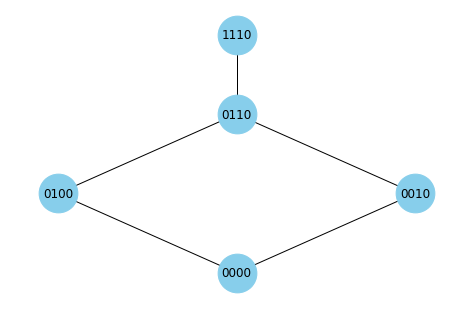

In [6]:
gammasEx = [[0,0.1,0.2,0.3],[0.3,0,0.4,0.1],[0.15,0.25,0,0.1],[0.1,0.2,0.3,0]]
alphasEx = [-1,2,3,-1]
isp = ISpoints(alphasEx, gammasEx)
G = graphIScoop(alphasEx,gammasEx,isp,ISglobalPoint(alphasEx,gammasEx,[0,0.1..100]))
drawIS(G)
plt.show()

### IS demo by changing the parameters

The IS changes by modifying the alpha parameters.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def demoGIS(a1,a2,a3,a4):
    gmm = [[0,0.2,0.2,0.2],[0.2,0,0.2,0.2],[0.2,0.2,0,0.2],[0.2,0.2,0.2,0]]
    alp = [a1,a2,a3,a4]
    isp = ISpoints(alp, gmm)
    G = graphIScoop(alp,gmm,isp,ISglobalPoint(alp,gmm,[0,0.1..100]))
    drawIS(G)
    plt.show()
    return isp

interact(demoGIS, 
         a1=FloatSlider(min=-3, max=3),
         a2=FloatSlider(min=-3, max=3),
         a3=FloatSlider(min=-3, max=3),
         a4=FloatSlider(min=-3, max=3))

<function demoGIS at 0x7f8398d284d0>

### Lotka-Volterra Transform

In [8]:
lvt([[1,2,3],[4,5,6],[7,8,9]], [[0,.5,.5],[.5,0,.5],[.5,.5,0]], .2)

[[13.5000000000000, 7.50000000000000, 6.50000000000000],
 [2.25000000000000, 3.00000000000000, 4.00000000000000],
 [0.642857142857142, 1.87500000000000, 3.16666666666667]]

# Monte Carlo method to approximate structural stability

## Comparison with values obtained by integration
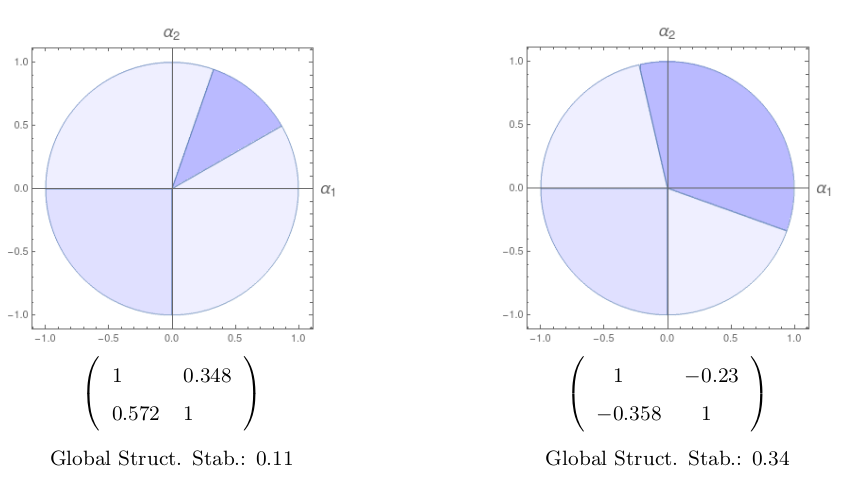

In [9]:
# 100.000 points, showing runtime
%time alfasMontecarlo([[1,0.348],[0.572, 1]], 100000).n()

CPU times: user 35.3 s, sys: 384 ms, total: 35.7 s
Wall time: 35.7 s


0.114500000000000

In [84]:
%time alfasMontecarlo([[1,-0.23],[-0.358, 1]], 100000).n()

CPU times: user 29.6 s, sys: 335 ms, total: 30 s
Wall time: 30 s


0.342750000000000

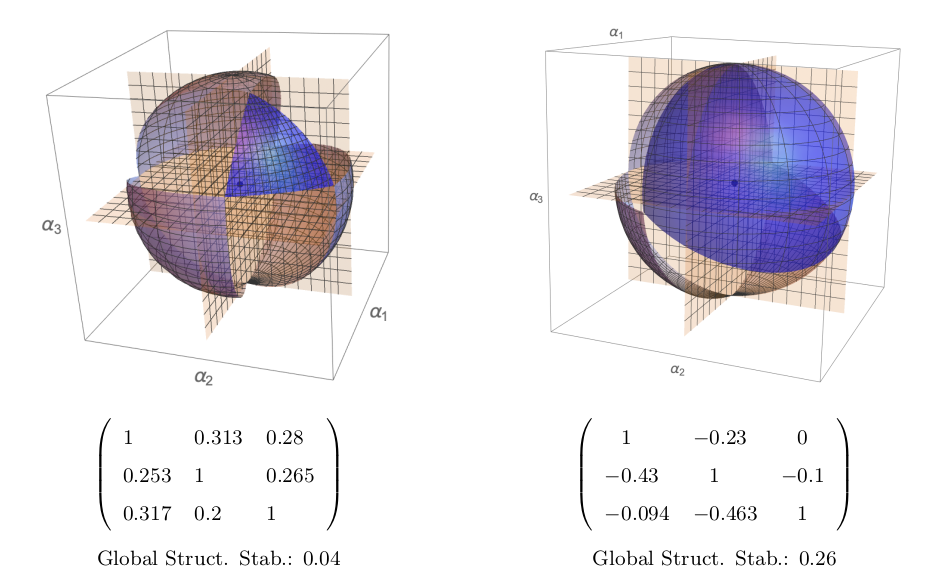

In [88]:
# 100.000 points, showing runtime
%time alfasMontecarlo([[1,0.313,0.28],[0.253,1,0.265],[0.317,0.2,1]], 100000).n()

CPU times: user 25.4 s, sys: 187 ms, total: 25.6 s
Wall time: 25.6 s


0.0398900000000000

In [10]:
%time alfasMontecarlo([[1,-0.23,0],[-0.43,1,-0.1],[-0.094,-0.463,1]], 100000).n()

CPU times: user 39.6 s, sys: 453 ms, total: 40.1 s
Wall time: 40.1 s


0.260730000000000

### Performance comparison 
With the alternative definition (same computation):

In [11]:
%time alfasMontecarlo2([[1,-0.23,0],[-0.43,1,-0.1],[-0.094,-0.463,1]], 10000).n()

CPU times: user 7.13 s, sys: 35.8 ms, total: 7.16 s
Wall time: 7.16 s


0.260500000000000

## Example with 9 nodes and 100.000 points (1 processor)
To check runtime

In [2]:
T = RealDistribution('gaussian',1)
m = Matrix([[1 if (i==j) else T.get_random_element()/9 for j in range(9)] for i in range(9)])
%time alfasMontecarlo2(m, 100000).n()

CPU times: user 2min 34s, sys: 553 ms, total: 2min 34s
Wall time: 2min 34s


0.00450000000000000

## Example with paralelization (4 processors, 100.000 points each)

In [3]:
m = Matrix([[1 if (i==j) else T.get_random_element()/9 for j in range(9)] for i in range(9)])

In [4]:
from sage.parallel.multiprocessing_sage import pyprocessing
import os

def alfasMontecarloN(datos):   # [matrix, points]
    npuntos = datos[1]
    T = RealDistribution('gaussian',1,seed=os.getpid())  # to change in each processor
    n = 0
    mat = Matrix(datos[0])
    l = len(datos[0][0])
    for i in range(npuntos):
        v = vector([T.get_random_element() for i in range(l)])
        w = vector(v/v.norm())
        if (min(mat \ w)>= 0):
            n+=1
    return n/npuntos


p_iter = pyprocessing(4)      # number of processors
P = parallel(p_iter=p_iter)
%time v = list(P(alfasMontecarloN)(list([[m,100000] for i in range(4)])))  # matrix m
sum([e[1] for e in v])/4.n()

CPU times: user 155 ms, sys: 79.9 ms, total: 235 ms
Wall time: 39.8 s


0.00186750000000000

Values in each processor: 

In [5]:
[e[1].n() for e in v]

[0.00187000000000000,
 0.00178000000000000,
 0.00182000000000000,
 0.00200000000000000]

### Example of the sphere (cooperative) with parallelization

In [6]:
mCoop3 = Matrix([[1,-0.23,0],[-0.43,1,-0.1],[-0.094,-0.463,1]])
p_iter = pyprocessing(4)      # number of processors
P = parallel(p_iter=p_iter)
%time v = list(P(alfasMontecarloN)(list([[mCoop3,100000] for i in range(4)])))  # matrix m
sum([e[1] for e in v])/4.n()

CPU times: user 25.9 ms, sys: 64.2 ms, total: 90.1 ms
Wall time: 39.5 s


0.260332500000000

<hr><h1>Graph parameters</h1>

In [1]:
# Only for preliminary tests

mat = [[1., -0.0773287, -0.094301, -0.205862, -0.0354986, -0.0212672, -0.0400461, -0.172104, -0.0831494], 
       [0.00887978,1., -0.108848, -0.166142, -0.00701173, 0.00760389, -0.113556, -0.050065, -0.184265], 
       [-0.131405, -0.0966938, 1., -0.0654117, -0.0903764, 0.00610861, -0.0996896, -0.0752048, -0.178559], 
       [0.00792954, -0.127425, 0.01592, 1., -0.193611, -0.00847181, -0.0858787, -0.1203, -0.161419], 
       [-0.0220568, -0.204898, -0.00108157, -0.0153087, 1., -0.168615, -0.207476, -0.0940354, -0.168022], 
       [-0.208586, -0.147953, -0.113378, -0.207653, -0.173221, 1., -0.0658157, -0.013101, -0.016159], 
       [-0.0697822, -0.0634864, -0.0183381, 0.0133589, -0.182359, 0.0232736, 1., -0.0476564, -0.12746], 
       [-0.100041, -0.146456, -0.0114768, -0.16555, -0.0741576, -0.186456, -0.182858, 1., -0.0461053], 
       [-0.146326, -0.125759, -0.00726797, 0.00275307, -0.166923, -0.00581787, -0.0243267, -0.194494, 1.]]

In [5]:
import csv 

from sage.graphs.graph_input import from_adjacency_matrix

def readcsvdatabase(filename): # Read a csv database and return a data matrix 
    startf=1   # rows to delete in database (heads)
    startc=1   # cols to delete in database  (species)
    lista=[]
    ifile  = open(filename)
    read = csv.reader(ifile)
    for row in read :
        lista.append(row[startc:])
    return Matrix([[float(j) for j in i] for i in lista[startf:]])

def mateq2adjmat(M): # equation matrix to adjacency matrix
     return Matrix([[abs(i) for i in row] for row in M])-1.*identity_matrix(nv)

def mateq2graph(M):  # equation matrix 2 graph
    g = Graph()
    from_adjacency_matrix(g, Matrix([[abs(i) for i in row] for row in mat])-identity_matrix(len(mat)),weighted=True)
    return g
    
def mean_degree(M):  # mean degree of a graph. The input is the adjacence matrix
    return sum([sum(row) for row in M])/len(list(M))

def optmod(g):  # optimal modularity of a graph using external C program igcop
    g.export_to_file('file.net', format='pajek')
    modu = ! ./igcop file.net    # Call C external program
    return modu

# Generating a random dim1+dim2 network from database
def submat():
    return DBM.matrix_from_rows_and_columns([x-1 for x in sr[randrange(0, cr)]],
                                            [y -1 for y in sc[randrange(0, cc)]])

# Generate subnetwork with adjacencymatrix of connected graph with beta as input
def submatadj():
    A=submat()
    M99=block_matrix([ [0*identity_matrix(dim1), A], 
                      [A.transpose(), 0*identity_matrix(dim2)] ], subdivide=False)
    while not Graph(M99).is_connected():
        A=submat()
        M99=block_matrix([ [0*identity_matrix(4), A], [A.transpose(), 0*identity_matrix(dim2)] ], subdivide=False)
    return M99

def normeachmatrix(M):   # Divide a matrix between the max ot the sum of its rows
    return M/max([sum(row) for row in M])

def alfasMontecarlo3(matriz, npuntos):   # Adaptation of alfasMontecarlo2   NOT NEEDED, aM2 rules.
    T = RealDistribution('gaussian',1,seed=os.getpid())
    n = 0
    l = nv   # difference with alfasMontecarlo2
    m = matrix(SR,l,l,matriz)
    vrs = vector([var('u'+str(i)) for i in range(l)])
    solut = m.solve_right(vrs)
    for i in range(npuntos):
        v = vector([T.get_random_element() for i in range(l)])
        w = vector(v/v.norm())
        if (min(solut(*w))>= 0):
            n+=1
    return n/npuntos

In [6]:
dim1=4
dim2=5 
nv= dim1+dim2
nmat=25 #number of matrices, 500 in the paper
beta=0.05

DBM=readcsvdatabase('M_SD_020.csv')   # reading database

In [7]:
sr=Subsets(DBM.nrows(),dim1).list()
sc=Subsets(DBM.ncols(),dim2).list()
cr=Subsets(DBM.nrows(),dim1).cardinality()
cc=Subsets(DBM.ncols(),dim2).cardinality()

In [ ]:
listamat=[normeachmatrix(submatadj()) for i in range(nmat)]   # Construye lista de matrices (beta=0)

In [10]:
listamat=[normeachmatrix(submatadj()) for i in range(nmat)]   # Construye lista de matrices (beta=0)

In [ ]:
mdlist=[mean_degree(A) for A in listamat]

In [11]:
omlist=[float(i) for i in flatten([optmod(Graph(A)) for A in listamat])]

In [12]:
mdlist

In [14]:
%time sslist=[alfasMontecarlo3(identity_matrix(nv)-listx, 1000).n() for listx in listamat]

<timed exec>:1: DeprecationWarning: Substitution using function-call syntax and unnamed arguments is deprecated and will be removed from a future release of Sage; you can use named arguments instead, like EXPR(x=..., y=...)
See http://trac.sagemath.org/5930 for details.


CPU times: user 36.2 s, sys: 170 ms, total: 36.4 s
Wall time: 36.4 s


In [15]:
r.cor(mdlist,omlist)

[1] 0.7911232

In [16]:
r.cor(mdlist,sslist)

[1] 0.8366532

In [17]:
r.cor(omlist,sslist)

[1] 0.7505651

In [18]:
import scipy.stats
scipy.stats.pearsonr(mdlist, sslist) 

(0.8366532412344535, 1.8781109562226316e-07)